In [1]:
import pandas as pd
from datetime import datetime
from zoe import find_latest, read_pickle, latest_map_data, find_previous, plot_study, plot_study_evolution

In [2]:
path, dt = find_latest('zoe_uk_active_cases_*.pickle', date_index=-2)
curr_date = pd.to_datetime(dt)
uk_active_cases = read_pickle(path)
print(path)
display(uk_active_cases)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-07-12_2021-07-12-18-02.pickle


,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,78562,None,None,86085.715275
2020-06-13,78563,None,None,79940.811469
2020-06-14,78564,None,None,74244.112992
2020-06-15,78565,None,None,68878.187593
2020-06-16,78566,None,None,64137.552455
...,...,...,...,...
2021-07-08,78953,None,None,420012.186271
2021-07-09,78954,None,None,430041.364601
2021-07-10,78955,None,None,438590.092522


In [3]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-07-11_2021-07-11-18-02.pickle


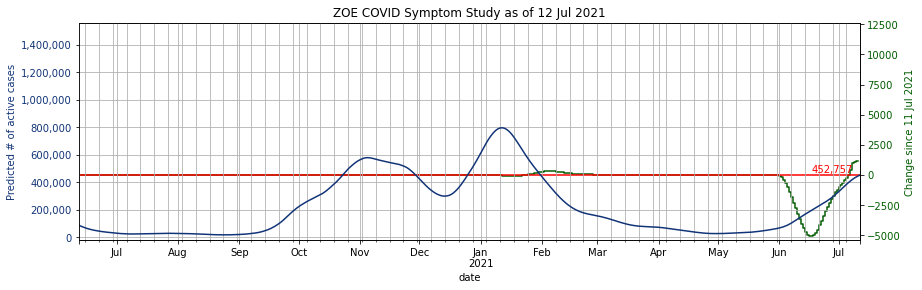

In [4]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

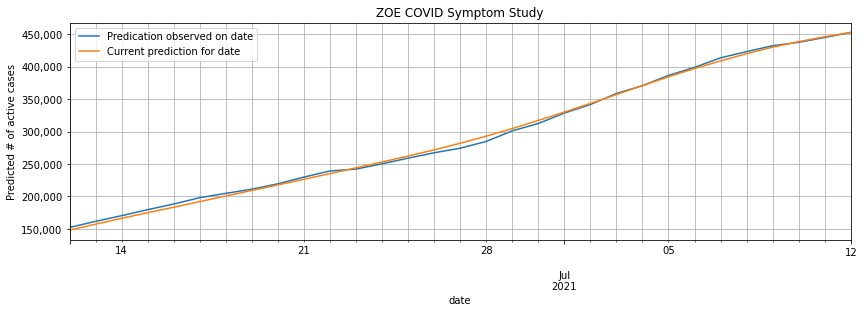

In [5]:
plot_study_evolution(curr_date, days=30)

In [6]:
for_date, prevalence_map = latest_map_data()
f'{for_date:%a %d %b %Y}'

'Mon 12 Jul 2021'

In [7]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
390,Dundee City,S12000042,3.009372
34,Stoke-on-Trent,E06000021,2.760719
324,East Dunbartonshire,S12000045,2.455721
277,St. Helens,E08000013,2.161008
320,West Lothian,S12000040,2.105783
285,South Tyneside,E08000023,2.009244
308,Perth and Kinross,S12000024,1.903574
270,Salford,E08000006,1.829382
313,Aberdeen City,S12000033,1.716893
309,Scottish Borders,S12000026,1.701396
